In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/
%cd /content/lag-llama
!pip install -r requirements.txt --quiet

Cloning into 'lag-llama'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 328 (delta 114), reused 108 (delta 85), pack-reused 162 (from 1)
Receiving objects: 100% (328/328), 234.56 KiB | 1.24 MiB/s, done.
Resolving deltas: 100% (155/155), done.
/content/lag-llama
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 20.6 MB/s eta 0:00:00

In [2]:
pip install gluonts[torch]==0.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: gluonts
    Found existing installation: gluonts 0.14.4
    Uninstalling gluonts-0.14.4:
      Successfully uninstalled gluonts-0.14.4


In [3]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 59.5MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


In [4]:
from itertools import islice

import matplotlib.dates as mdates
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [5]:
pip install yfinance==0.2.37

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.42
    Uninstalling yfinance-0.2.42:
      Successfully uninstalled yfinance-0.2.42


In [6]:
def _get_lag_llama_dataset(dataset):
    # avoid mutations
    dataset = dataset.copy()

    # convert numerical columns to `float32`
    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(
            dataset[col]
        ):
            dataset[col] = dataset[col].astype("float32")

    # create a `PandasDataset`
    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset




In [7]:
import yfinance as yf

In [104]:


ckpt = torch.load("lag-llama.ckpt", map_location=torch.device("cuda:0"))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=1,
        context_length=64,
        # estimator arguments
       nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=100,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

<ipython-input-104-272d9ba25028>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=torch.device("cuda:0"))


In [114]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# List of 10 important stock tickers including AAPL
tickers = ["AAPL"]

# Fetch stock price data for each ticker
stock_data = {}
for ticker in tickers:
    stock_data[ticker] = (
        yf.Ticker(ticker)
        .history(period="max", start="1900-01-01", end="2023-01-01")["Close"]
        .resample('1d')
        .ffill()
    )

# Combine all stock data into a single DataFrame
stock_prices = pd.DataFrame(stock_data)

# # Initialize the scaler
# scaler = RobustScaler()

# # Fit and transform the stock price data
stock_prices_scaled = pd.DataFrame(
    stock_prices,  # Keep original data as requested
    index=stock_prices.index,
    columns=stock_prices.columns
)

# Assuming _get_lag_llama_dataset is a custom function, you can now use it
train_dataset = _get_lag_llama_dataset(stock_prices_scaled)


In [115]:
from gluonts.dataset.util import to_pandas
entry = next(iter(train_dataset))
train_series = to_pandas(entry)
train_series

/usr/local/lib/python3.10/dist-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


,0
1980-12-12,0.098943
1980-12-13,0.098943
1980-12-14,0.098943
1980-12-15,0.093781
1980-12-16,0.086898
...,...
2022-12-26,130.631363
2022-12-27,128.818420
2022-12-28,124.865585
2022-12-29,128.402344


In [116]:
predictor = estimator.train(
    train_dataset,
    cache_data=True,
    shuffle_buffer_length=1000,
)

/usr/local/lib/python3.10/dist-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
INFO: GPU available: True (cuda), used: True
INFO:lightning.p

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.54286 (best 0.54286), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.54286 (best 0.54286), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -0.91038 (best -0.91038), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -0.91038 (best -0.91038), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO: Epoch 3, global step 200: 'trai

# after fine tuning with 11 year and test on 60 day

In [117]:
import yfinance as yf
# دانلود داده‌های سهام
ticker = 'AAPL'  # به عنوان مثال: Apple Inc.
stock_returns = yf.download(ticker, start="2023-01-01", end="2024-01-01")['Close'].resample('1D').ffill()
stock_returns

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2023-01-03,125.070000
2023-01-04,126.360001
2023-01-05,125.019997
2023-01-06,129.619995
2023-01-07,129.619995
...,...
2023-12-25,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [118]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar
import torch
def _get_lag_llama_dataset(dataset):
    # avoid mutations
    dataset = dataset.copy()

    # convert numerical columns to `float32`
    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(
            dataset[col]
        ):
            dataset[col] = dataset[col].astype("float32")

    # create a `PandasDataset`
    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset




context_length = 64
prediction_length = 1  # پیش‌بینی برای روز بعد
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 4. حلقه برای پیش‌بینی کل داده‌ها با نوار پیشرفت
predicted_values = []
predicted_samples = []
results = []  # برای ذخیره نتایج نهایی

# استفاده از tqdm برای نمایش درصد پیشرفت
for i in tqdm(range(context_length, len(stock_returns) - prediction_length), desc="Processing"):
    # آماده‌سازی داده‌های ورودی
    input_data = stock_returns[i - context_length:i+1].to_frame()

    # آماده‌سازی dataset
    backtest_dataset = _get_lag_llama_dataset(input_data)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=100
    )
    # دریافت پیش‌بینی برای روز بعد
    forecasts = list(tqdm(forecast_it, total=len(test_dataset), desc="Forecasting batches"))
    # استخراج اطلاعات مورد نیاز
    raw_forecast = np.mean(forecasts[0].samples)
    y_actual = stock_returns[input_data.index[-1]]
    train_start_date = input_data.index[0]
    train_end_date = input_data.index[-2]
    predict_date =  input_data.index[-1]
    batch_size = len(backtest_dataset)

    # ذخیره نتایج در یک دیکشنری
    result = {
        "input_index": i,
        "samples": np.mean(forecasts[0].samples),
        "train_start_date": train_start_date,
        "train_end_date": train_end_date,
        "predict_date": predict_date,
        "raw_forecast": raw_forecast,
        "y_actual": y_actual,
        "batch_size": batch_size,
        "context_len": context_length,
        "input_patch_len": len(input_data)
    }

    results.append(result)



# تبدیل نتایج به DataFrame
results_df = pd.DataFrame(results)





Processing:   0%|          | 0/296 [00:00<?, ?it/s]

Forecasting batches: 100%|██████████| 1/1 [00:00<00:00, 27.27it/s]


Forecasting batches: 100%|██████████| 1/1 [00:00<00:00, 29.56it/s]


Forecasting batches: 100%|██████████| 1/1 [00:00<00:00, 29.63it/s]

Processing:   1%|          | 3/296 [00:00<00:13, 21.92it/s]

Forecasting batches: 100%|██████████| 1/1 [00:00<00:00, 28.13it/s]


Forecasting batches: 100%|██████████| 1/1 [00:00<00:00, 26.91it/s]


Forecasting batches: 100%|██████████| 1/1 [00:00<00:00, 33.73it/s]

Processing:   2%|▏         | 6/296 [00:00<00:13, 21.64it/s]

Forecasting batches: 100%|██████████| 1/1 [00:00<00:00, 37.61it/s]


Forecasting batches: 100%|██████████| 1/1 [00:00<00:00, 34.74it/s]


Forecasting batches: 100%|██████████| 1/1 [00:00<00:00, 33.47it/s]

Processing:   3%|▎         | 9/296 [00:00<00:12, 22.96it/s]

Forecasting batches: 100%|██████████| 1/1 [00:00<00:00, 34.77it/s]


Forecasting batches: 100%|██████████| 1/1 [00:00<00:00, 37.34it/s]


Forecas

In [119]:
results_df

,input_index,samples,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,batch_size,context_len,input_patch_len
0,64,170.692657,2023-01-03,2023-03-07,2023-03-08,170.692657,152.869995,1,64,65
1,65,171.583557,2023-01-04,2023-03-08,2023-03-09,171.583557,150.589996,1,64,65
2,66,168.747681,2023-01-05,2023-03-09,2023-03-10,168.747681,148.500000,1,64,65
3,67,167.199417,2023-01-06,2023-03-10,2023-03-11,167.199417,148.500000,1,64,65
4,68,167.338333,2023-01-07,2023-03-11,2023-03-12,167.338333,148.500000,1,64,65
...,...,...,...,...,...,...,...,...,...,...
291,355,219.619888,2023-10-21,2023-12-23,2023-12-24,219.619888,193.600006,1,64,65
292,356,220.122513,2023-10-22,2023-12-24,2023-12-25,220.122513,193.600006,1,64,65
293,357,220.874634,2023-10-23,2023-12-25,2023-12-26,220.874634,193.050003,1,64,65
294,358,221.792557,2023-10-24,2023-12-26,2023-12-27,221.792557,193.149994,1,64,65


In [120]:
# ذخیره DataFrame به صورت pickle
results_df.to_pickle('fine_tune_1900_lr.pkl')

# نمایش پیغام موفقیت‌آمیز بودن عملیات
print("DataFrame successfully saved as 'fine_tune_diff_2000.pkl'.")


DataFrame successfully saved as 'fine_tune_diff_2000.pkl'.


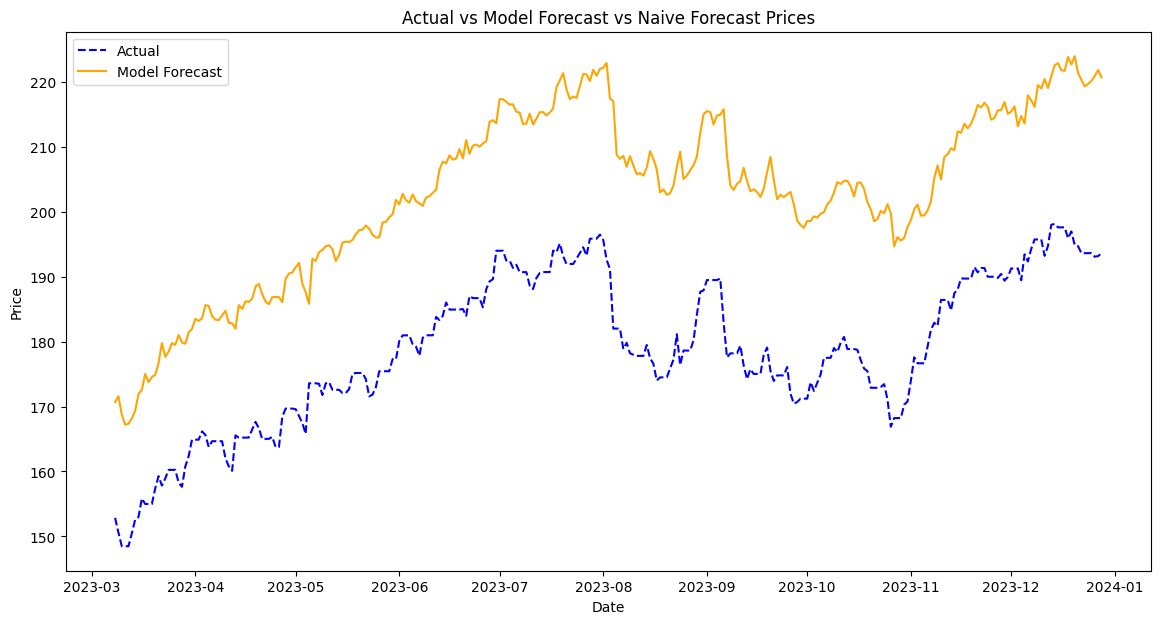

In [121]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['predict_date'], results_df['y_actual'], label='Actual', color='blue', linestyle='--')
plt.plot(results_df['predict_date'], results_df['raw_forecast'], label='Model Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Model Forecast vs Naive Forecast Prices')
plt.legend()
plt.show()

In [122]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score

def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_results_for_context_len(context_len, results_by_context_len):
    # فیلتر کردن داده‌ها برای context_len مشخص شده
    context_results_df =results_by_context_len

    mse_value = calculate_mse(context_results_df)
    accuracy_value = calculate_accuracy(context_results_df)
    profit = calculate_profit(context_results_df)
    direction_accuracy = calculate_direction_accuracy(context_results_df)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
    direction_profit = calculate_direction_profit(context_results_df)

    # ساخت دیکشنری از نتایج محاسبه شده
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# فراخوانی تابع برای یک context_len خاص
context_len = 64  # برای مثال
final_result_df = calculate_results_for_context_len(context_len, results_df)
print(final_result_df)


   context_len         mse  accuracy  direction_accuracy  \
0           64  591.529102  0.376271            0.498305   

   actual_direction_accuracy  direction_profit     profit  
0                   0.376271          14.91563  26.630476  


In [123]:
initial_investment = 100
initial_price = results_df['y_actual'].iloc[0]
final_price = results_df['y_actual'].iloc[-1]


# Calculate the number of shares bought initially
shares_bought = initial_investment / initial_price

# Calculate the final value of the investment
final_investment_value = shares_bought * final_price

# Calculate the total profit
buy_and_hold_profit = final_investment_value - initial_investment
buy_and_hold_profit

26.630475576753682